In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

#load boston dataset
boston = load_boston()
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

bostonDF['PRICE'] = boston.target
print('Size of dataset :',bostonDF.shape)
bostonDF.head()

Size of dataset : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Feature information
CRIM: 지역별 범죄 발생률  
ZN: 25,000평방피트를 초과하는 거주 지역의 비율  
NDUS: 비상업 지역 넓이 비율  
CHAS: 찰스강에 대한 더미 변수(강의 경계에 위치한 경우는 1, 아니면 0)  
NOX: 일산화질소 농도  
RM: 거주할 수 있는 방 개수  
AGE: 1940년 이전에 건축된 소유 주택의 비율  
DIS: 5개 주요 고용센터까지의 가중 거리  
RAD: 고속도로 접근 용이도  
TAX: 10,000달러당 재산세율  
PTRATIO: 지역의 교사와 학생 수 비율  
B: 지역의 흑인 거주 비율  
LSTAT: 하위 계층의 비율  
MEDV: 본인 소유의 주택 가격(중앙값)  

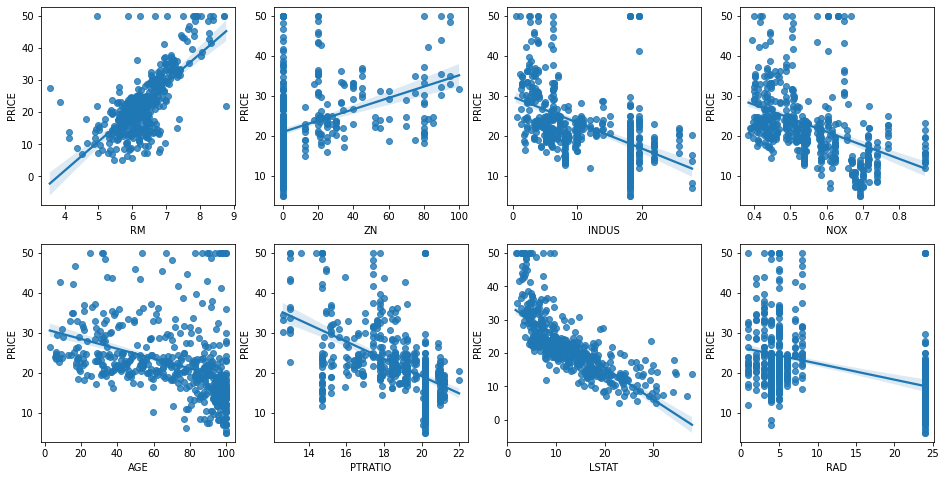

In [6]:
#check feature importance
fig, axs = plt.subplots(figsize=(16,8), ncols=4 ,nrows=2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

**RM, LSTAT seems to be important feature**

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'],axis=1, inplace=False)

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse,rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test,y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


In [10]:
print('Intercept :', lr.intercept_)
print('Weights :', np.round(lr.coef_,1))

Intercept : 40.995595172165
Weights : [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [12]:
coeff = pd.Series(data=np.round(lr.coef_,1), index = X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [14]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

# 5 fold validation
neg_mse_scores = cross_val_score(lr,X_data,y_target, scoring="neg_mean_squared_error",cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('Each negative MSE scores :',np.round(neg_mse_scores,2))
print('Each RMSE scores :',np.round(rmse_scores,2))
print('mean RMSE : {0:.3f}'.format(avg_rmse))

Each negative MSE scores : [-12.46 -26.05 -33.07 -80.76 -33.31]
Each RMSE scores : [3.53 5.1  5.75 8.99 5.77]
mean RMSE : 5.829


## Polynomial Regression

**if [x1,x2] = [0 1]**  
**make it [1, x1=0, x2=1, x1x2=0, x1^2=0, x2^2=1] = [1 0 1 0 0 1]**

In [15]:
from sklearn.preprocessing import PolynomialFeatures

X = np.arange(4).reshape(2,2)
print('Linear :\n',X)

#make it degree 2
poly = PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr = poly.transform(X)
print('Square :\n',poly_ftr)

Linear :
 [[0 1]
 [2 3]]
Square :
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


In [16]:
from sklearn.pipeline import Pipeline

def polynomial_func(X):
    y = 1 + 2*X[:,0] + 3*X[:,0]**2 + 4*X[:,1]**3 # y = 1 + 2x1 + 3x1^2 + 4x2^3
    return y

#connect Polynomual Feature and Linear Regression by Pipeline
model = Pipeline([('poly',PolynomialFeatures(degree=3)),
                 ('linear',LinearRegression())])
X = np.arange(4).reshape(2,2) #[[0,1],[2,3]]
y = polynomial_func(X)

model = model.fit(X,y)

print('Polynomial weights\n',np.round(model.named_steps['linear'].coef_,2))

Polynomial weights
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]


## Apply Polynomial Regression to Boston

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import numpy as np

boston = load_boston()
bostonDF = pd.DataFrame(data=boston.data, columns = boston.feature_names)

y_target = boston.target
X_data = bostonDF

X_train,X_test,y_train,y_test = train_test_split(X_data,y_target,test_size=0.3,random_state=156)

#connect with Pipeline
p_model = Pipeline([('poly',PolynomialFeatures(degree=2, include_bias=False)),
                   ('linear',LinearRegression())])
p_model.fit(X_train,y_train)
y_preds = p_model.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f} , RMSE : {1:.3f}'.format(mse,rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test,y_preds)))

MSE : 15.556 , RMSE : 3.944
Variance score : 0.782


1. Too high degree can make overfitting.  
2. In this case, make 'include_bias = False' makes better performance.